This tutorial guides you on how to train a Gradient Boosting model using decision trees with the `tf.estimator` APIs. Boosted trees are the popular ML approach for both regression and classification. It is a kind of ensemble technique to summarize the result from many tree models.


Reference:
* Boosted trees: https://www.tensorflow.org/tutorials/estimator/boosted_trees

In [0]:
!pip install -q tf-nightly

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

print("Tensorflow Version: {}".format(tf.__version__))
print("Eager Mode: {}".format(tf.executing_eagerly()))
print("GPU {} available".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200113
Eager Mode: True
GPU is available


# Data Preprocessing and Exploring

In [0]:
dftrain = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
dfeval = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")
y_train = dftrain.pop("survived")
y_eval = dfeval.pop("survived")

In [4]:
dftrain.head(5)

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [6]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

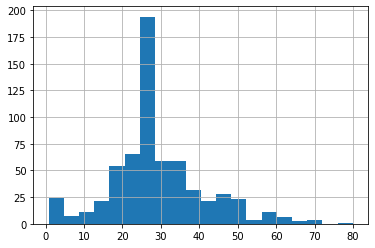

In [12]:
dftrain["age"].hist(bins=20)
plt.show()

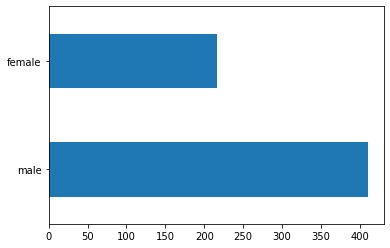

In [14]:
dftrain["sex"].value_counts().plot(kind="barh")
plt.show()

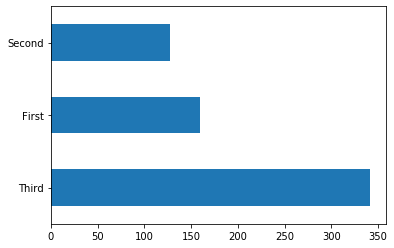

In [16]:
dftrain["class"].value_counts().plot(kind='barh')
plt.show()

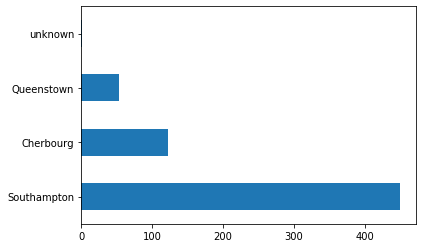

In [19]:
dftrain["embark_town"].value_counts().plot(kind='barh')
plt.show()

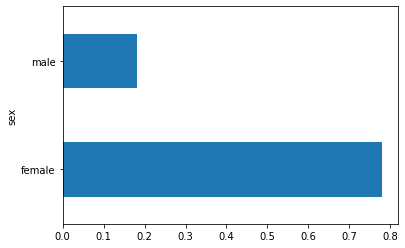

In [25]:
pd.concat([dftrain, y_train], axis=1).groupby(['sex'])["survived"].mean().plot(kind='barh')
plt.show()

# Create Feature Columns and Input functions

In [0]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [0]:
feature_columns = []

for feat in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feat].unique()
  feature_columns.append(tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(
      key=feat, vocabulary_list=vocabulary
    )
  ))

for feat in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(key=feat))

Let's inspect the data first.

In [37]:
example_data = dftrain.iloc[:10,:]
example_data

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
5,male,2.0,3,1,21.0750,Third,unknown,Southampton,n
6,female,27.0,0,2,11.1333,Third,unknown,Southampton,n
7,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n
8,female,4.0,1,1,16.7000,Third,G,Southampton,n
9,male,20.0,0,0,8.0500,Third,unknown,Southampton,y


In [38]:
class_feat = tf.keras.layers.DenseFeatures([feature_columns[3]])(dict(example_data))
class_feat.numpy()

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

Now you can create an input function that feeds the dataset and the label into the model during training and evaluation.

In [0]:
NUM_EXAMPLES = len(dftrain)

def make_input_fn(X, y, n_epochs=1, shuffle=True, batch_size=NUM_EXAMPLES):
  def input_fn():
    # repeat == None: endless repeat
    ds = tf.data.Dataset.from_tensor_slices((dict(X), y)).repeat(n_epochs)
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size)  # no need to do shuffle due to in-memory data
    return ds
  return input_fn

In [0]:
train_input_fn = make_input_fn(dftrain, y_train, n_epochs=None)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=1)

You can also use the input_fn method to get a batch of dataset.

In [47]:
_ds = make_input_fn(dfeval, y_eval, shuffle=False, batch_size=3)()
_ds

<BatchDataset shapes: ({sex: (None,), age: (None,), n_siblings_spouses: (None,), parch: (None,), fare: (None,), class: (None,), deck: (None,), embark_town: (None,), alone: (None,)}, (None,)), types: ({sex: tf.string, age: tf.float64, n_siblings_spouses: tf.int32, parch: tf.int32, fare: tf.float64, class: tf.string, deck: tf.string, embark_town: tf.string, alone: tf.string}, tf.int32)>

In [51]:
for _data, _label in _ds.take(1):
  print(_data.keys())
  print(_data['sex'].numpy())
  print(_label)

dict_keys(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone'])
[b'male' b'male' b'female']
tf.Tensor([0 0 1], shape=(3,), dtype=int32)


# Training, Evaluating and Predicting

The following is a linear model as the baseline.

In [56]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# train the model
linear_est.train(input_fn=train_input_fn, max_steps=100)

# evaluate the model
result = linear_est.evaluate(input_fn=eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832537
auc_precision_recall      0.793507
average_loss              0.478823
label/mean                0.375000
loss                      0.478823
precision                 0.703297
prediction/mean           0.359217
recall                    0.646465
global_step             100.000000
dtype: float64


Next you are going to build a Boosted Trees model. Both regression and classification are supported via the `BoostedTreesClassifier` and the `BoostedTreesClassifier` API respectively.

In [75]:
# Because all dataset is loaded into the memory, use entire dataset per layer.
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns=feature_columns,
                                          n_batches_per_layer=n_batches)

# train the model
est.train(train_input_fn, max_steps=100)

# evaluate the model
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.837121
accuracy_baseline         0.625000
auc                       0.864034
auc_precision_recall      0.843593
average_loss              0.425569
label/mean                0.375000
loss                      0.425569
precision                 0.811111
prediction/mean           0.389892
recall                    0.737374
global_step             100.000000
dtype: float64


Make the prediction.

In [76]:
preds = list(est.predict(eval_input_fn))
preds[:2]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpqzez7dqy/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object),
  'class_ids': array([1]),
  'classes': array([b'1'], dtype=object),
  'logistic': array([0.90696084], dtype=float32),
  'logits': array([2.2770786], dtype=float32),
  'probabilities': array([0.09303918, 0.90696084], dtype=float32)},
 {'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'logistic': array([0.04018185], dtype=float32),
  'logits': array([-3.1733286], dtype=float32),
  'probabilities': array([0.9598181 , 0.04018184], dtype=float32)}]

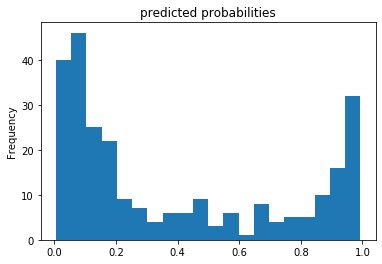

In [77]:
probs = pd.Series([pred["probabilities"][1] for pred in preds])
probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

Draw the roc curve.

In [0]:
from sklearn.metrics import roc_curve

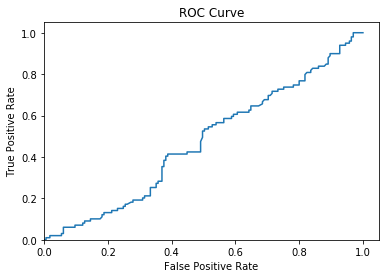

In [79]:
fpr, tpr, _ = roc_curve(y_eval, probs)

plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()